Osnabrück University - Machine Learning (Summer Term 2018) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 06

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, May 20, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups designated tutor or whomever of us you run into first. Please upload your results to your group's studip folder.

## Assignment 0: Math recap (Hyperplanes) [2 Bonus Points]

This exercise is supposed to be very easy and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is a *hyperplane*? What are the hyperlanes in $\mathbb{R}^2$ and $\mathbb{R}^3$? How are the usually described?

A hyperplane is a subspace that has one less dimensio than its ambient space. A hpyerplane in $\mathbb{R}^2$ is $\mathbb{R}^1$ (a line) and a hyperplane in $\mathbb{R}^3$ is $\mathbb{R}^2$ (a plane).  

**Description:**  
$$\vec{x}\cdot\vec{n} = d$$
where $\vec{x}$ is a position vector of a point, $\cdot$ is the dot product and $d$ is the distance to the origin. All points that fulfill this equation lie on(inside?) the hyperplane.

**b)** What is the Hesse normal form? What is the intuition behind? What are its advantages?

**Definition**  
The Hesse normal form is a special type of equation which describes a line in $\mathbb{R}^2$ or a plane in $\mathbb{R}^3$ (or even higher-dimensional hyperplanes) through a unit normal vector and the distance to the origin. The Hesse normal form is useful when wanting to calculate the distance of a point to a plane or a line. 

**Intuition**  

**Advatages**

**c)** Can you transform the standard form of a hyperplane into the Hesse normal form and vice versa?

Yes, the standard form of a hyperplane can be transformed into the Hesse normal form and vice versa:
\begin{align*}
\vec{x}\cdot\vec{n} &= d \\
\Rightarrow \sum_{i=1}^n x_in_i &= 0
\end{align*}

## Assignment 1: Local PCA (8 Points)

In the lecture we learned that regular PCA is ill suited for special cases of data. In this assignment we will take a look at local PCA which is used for clustered data (ML-06, Slide 25). This is mostly a repetition of algorithms we already used. Feel free to use the built-in functions for k-means clustering and PCA from the libraries (we already included the right imports to set you on track).

<IPython.core.display.Javascript object>


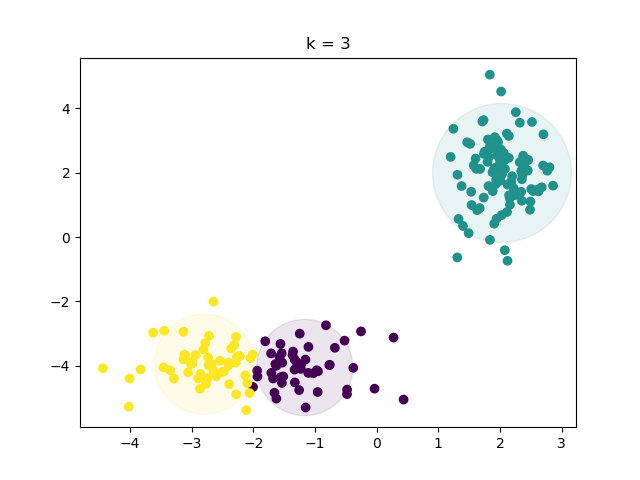

<IPython.core.display.Javascript object>


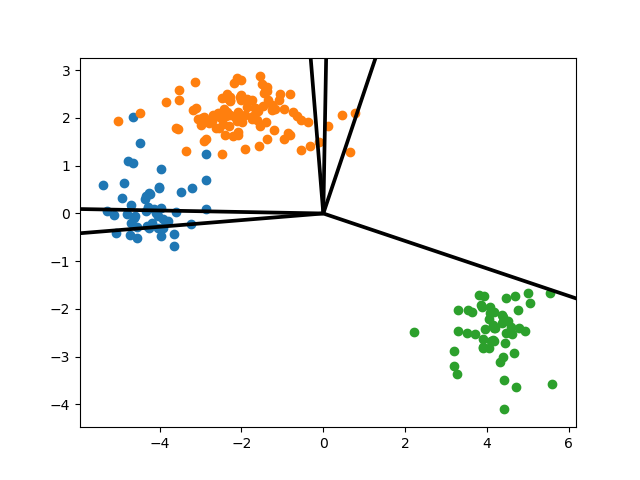

<IPython.core.display.Javascript object>


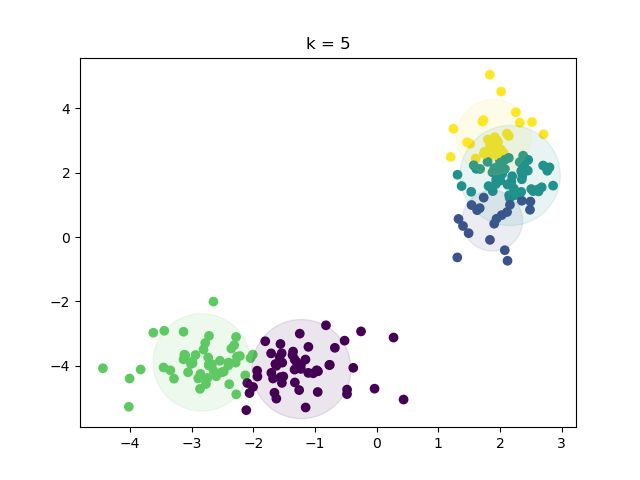

<IPython.core.display.Javascript object>


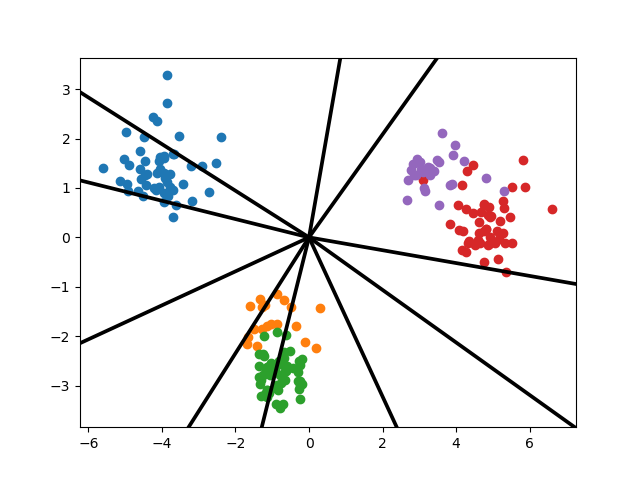

<IPython.core.display.Javascript object>


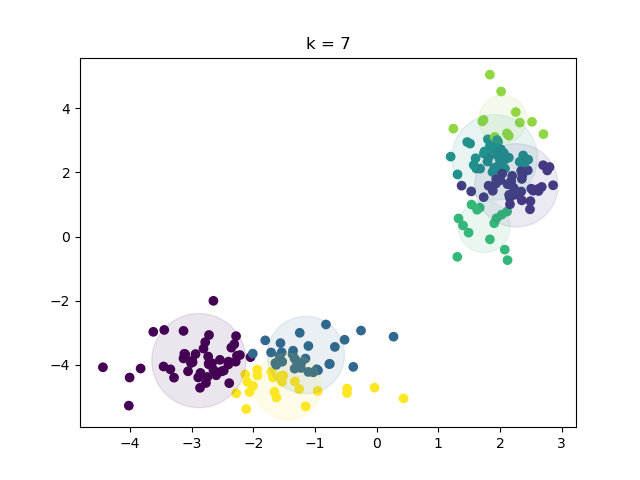

<IPython.core.display.Javascript object>


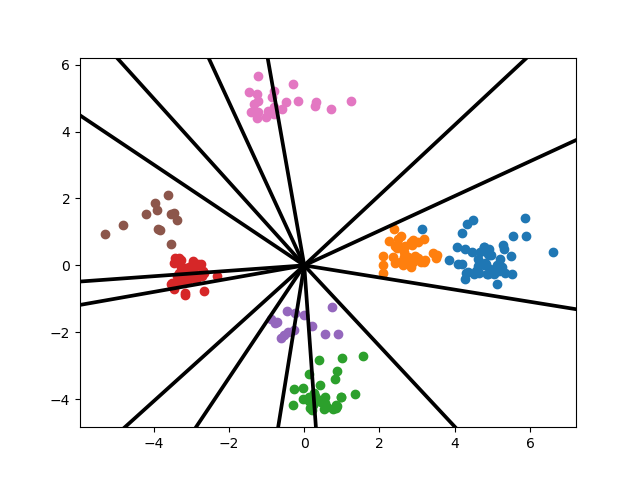

In [2]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd
import matplotlib.colors as mplc
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal as multNorm

from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition.pca import PCA

def pdist2(x, y):
    """
    Pairwise distance between all points of two datasets.
    
    Args:
        x (ndarray): Containing j data points of dimension n. Shape (j, n).
        y (ndarray): Containing k data points of dimension n. Shape (k, n).
        
    Returns:
        ndarray: Pairwise distances between all data points. Shape (j, k).
    """
    distance_mat = np.empty((x.shape[0], y.shape[0]))
    for i in range(y.shape[0]):
        distance_mat[:, i] = np.linalg.norm(x - y[i], axis=-1)
    return distance_mat

# Generate clustered data - you may plot the data to take a look at it
data = np.vstack((multNorm([2,2],[[0.1, 0], [0, 1]],100), multNorm([-2,-4],[[1, 0], [0, 0.3]],100)))

# colors = ['indianred','steelblue','yellowgreen','lightseegreen','wheat','purple','sandybrown']
colors = ['red','blue','green','cyan','yellow','magenta','orange']

# Apply k-means to the data (for k=1,3,5)
for k in [3, 5, 7]:
    centroids, distortion = kmeans(data, k)
    
    # Generate distance matrix for all observations with all centroids
    distances = pdist2(data, centroids)
    # Assign data to best matching centroid
    labels = [min_c for min_c in np.argmin(distances, axis=1)]

    # Plot the results of k-means
    fig = plt.figure('k-means for k ={}'.format(k))
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], 
                c=list(set(labels)), alpha=.1, marker='o',
                s=np.array([np.count_nonzero(labels==label) for label in set(labels)])*100)
    plt.title('k = {}'.format(k))
    
    # Plot the results of local PCA
    pca_fig = plt.figure('projected data and components for k ={}'.format(k))
    comps = np.array([[0, 0]])
    # Apply PCA for each cluster and store each two largest components.
    for i, cluster in enumerate(centroids):
        pca = PCA(n_components=2)
        cluster_data = np.array([data[idx] for idx,label in enumerate(labels) if label == i])
        pca.fit(cluster_data)
        comps = np.concatenate((comps, [pca.components_[0,:]]), axis=0)
        comps = np.concatenate((comps, [pca.components_[1,:]]), axis=0)
        # row_sums = cluster_data.sum(axis=1)
        # proj = cluster_data / row_sums[:, np.newaxis]
        proj = np.array(cluster_data @ pca.components_)
        plt.scatter(proj[:,0], proj[:,1], c=np.zeros(proj.shape[0]).fill(i))
    
    comps = np.delete(comps, 0, 0)
    filler = np.zeros(len(comps))
    plt.quiver(filler, filler, comps[:,0], comps[:,1], scale=0.2) #, color=colors, scale=1)
    

## Assignment 2: Data Visualization and Chernoff Faces (6 Points)

The following exercise contains no programming (unless you want to go through the implementation). Answer the questions that are posted below the code segment (and run the code before - it's really worth it!). In case you are even more interested - here is a link to the [original paper](http://www.dtic.mil/cgi-bin/GetTRDoc?AD=AD0738473).

<IPython.core.display.Javascript object>


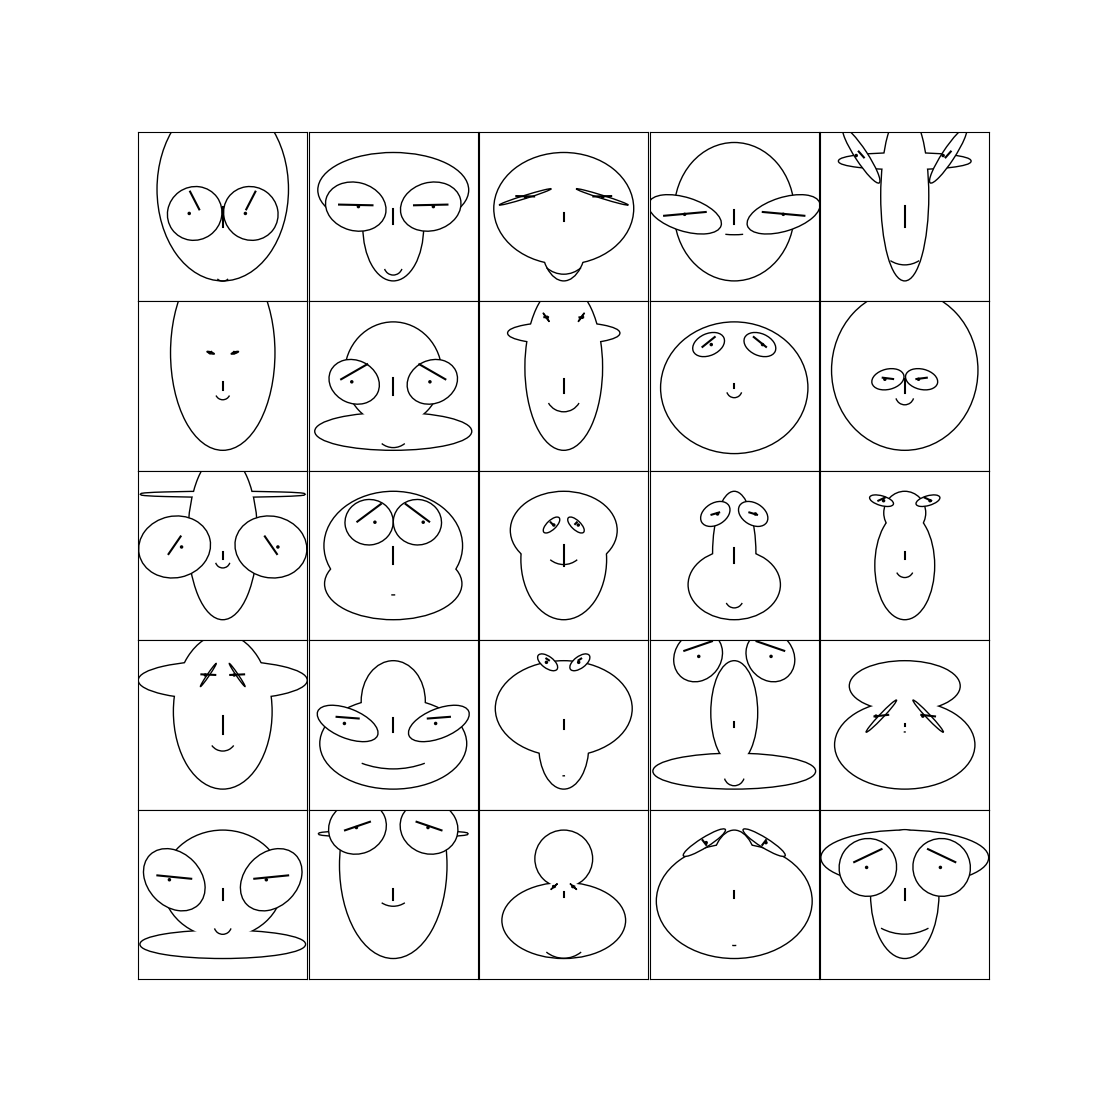

In [39]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Arc
from numpy.random import rand
import numpy as np

def cface(ax, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18):
    """
    This implementation of chernov faces is taken from Abraham Flaxman. You can
    find the original source files here: https://gist.github.com/aflaxman/4043086
    Only minor adjustments have been made.

     x1 = height  of upper face
     x2 = overlap of lower face
     x3 = half of vertical size of face
     x4 = width of upper face
     x5 = width of lower face
     x6 = length of nose
     x7 = vertical position of mouth
     x8 = curvature of mouth
     x9 = width of mouth
     x10 = vertical position of eyes
     x11 = separation of eyes
     x12 = slant of eyes
     x13 = eccentricity of eyes
     x14 = size of eyes
     x15 = position of pupils
     x16 = vertical position of eyebrows
     x17 = slant of eyebrows
     x18 = size of eyebrows
    """

    # transform some values so that input between 0,1 yields variety of output
    x3 = 1.9 * (x3 - .5)
    x4 = (x4 + .25)
    x5 = (x5 + .2)
    x6 = .3 * (x6 + .01)
    x8 = 5 * (x8 + .001)
    x11 /= 5
    x12 = 2 * (x12 - .5)
    x13 += .05
    x14 += .1
    x15 = .5 * (x15 - .5)
    x16 = .25 * x16
    x17 = .5 * (x17 - .5)
    x18 = .5 * (x18 + .1)

    # top of face, in box with l=-x4, r=x4, t=x1, b=x3
    e = Ellipse((0, (x1 + x3) / 2), 2 * x4, (x1 - x3), ec='black', linewidth=2)
    ax.add_artist(e)

    # bottom of face, in box with l=-x5, r=x5, b=-x1, t=x2+x3
    e = Ellipse((0, (-x1 + x2 + x3) / 2), 2 * x5, (x1 + x2 + x3), fc='white', ec='black', linewidth=2)
    ax.add_artist(e)

    # cover overlaps
    e = Ellipse((0, (x1 + x3) / 2), 2 * x4, (x1 - x3), fc='white', ec='none')
    ax.add_artist(e)
    e = Ellipse((0, (-x1 + x2 + x3) / 2), 2 * x5, (x1 + x2 + x3), fc='white', ec='none')
    ax.add_artist(e)

    # draw nose
    plt.plot([0, 0], [-x6 / 2, x6 / 2], 'k')

    # draw mouth
    p = Arc((0, -x7 + .5 / x8), 1 / x8, 1 / x8, theta1=270 - 180 / np.pi * np.arctan(x8 * x9),
            theta2=270 + 180 / np.pi * np.arctan(x8 * x9))
    ax.add_artist(p)

    # draw eyes
    p = Ellipse((-x11 - x14 / 2, x10), x14, x13 * x14, angle=-180 / np.pi * x12, fc='white', ec='black')
    ax.add_artist(p)

    p = Ellipse((x11 + x14 / 2, x10), x14, x13 * x14, angle=180 / np.pi * x12, fc='white', ec='black')
    ax.add_artist(p)

    # draw pupils
    p = Ellipse((-x11 - x14 / 2 - x15 * x14 / 2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)
    p = Ellipse((x11 + x14 / 2 - x15 * x14 / 2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)

    # draw eyebrows
    plt.plot([-x11 - x14 / 2 - x14 * x18 / 2, -x11 - x14 / 2 + x14 * x18 / 2],
             [x10 + x13 * x14 * (x16 + x17), x10 + x13 * x14 * (x16 - x17)], 'k')
    plt.plot([x11 + x14 / 2 + x14 * x18 / 2, x11 + x14 / 2 - x14 * x18 / 2],
             [x10 + x13 * x14 * (x16 + x17), x10 + x13 * x14 * (x16 - x17)], 'k')


fig = plt.figure('Chernoff Faces', figsize=(11, 11))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, aspect='equal')
    cface(ax, .9, *rand(17))
    ax.axis([-1.2, 1.2, -1.2, 1.2])
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace=0, wspace=0)
fig.canvas.draw()


### a) Data Visualization Techniques

Why do we need data visualization techniques and what are techniques to visualize high dimensional data?

Automated analysis of high-dimensional data is rarely possible, but humans have remarkable pattern recognition abilities, so visualizing data for humans to analyze is an important field of study.  

**Available Techniques:**

- PCA
    - reduce dimensions and project data onto those to display
- Scatterplot Matrix
    - project onto 2 dimensions and display all combinations as scatterplots
- Glyphs 
    - use some kind of geometry, where each dimension controls one parameter of the geometry
    - Chernovb Faces: map dimensions onto features of a face (as was done in the above plot)
- Parallel Coordinate Plots
    - make *columns* for each dimension and connect them via lines

### b) Chernoff faces

Why did Chernoff use faces for his representation? Why not something else, like dogs or houses?

Humans have a highly developed ability for (human) facial recognition, so it makes sense to show data features using human faces. Our ability to distinguish faces of other animals is rather poor. Also, for items such as houses, there may be less features availabe that can be varied in an easily recognisable way.

### c) Alternatives

Explain at least one other data visualization technique from the lecture.

The **Parallel Coordinate Plot** maps the different features/dimensions of data onto columns on the x-axis and the the values for those features is mapped onto the y-axis. Then, one line per datum is drawn from the first to the last column, at the height that represent the value of the respective feature.

What is somewhat troublesome when using these kinds of plots is that scaling makes a huge difference (maybe the ranges of values for different features vary a lot) in terms of interpretability and navigation becomes harder the more data (e.g. lines) are present.

**Example Image:**

![Sorry, could not load image...](https://www.researchgate.net/profile/Elmar_Kiesling/publication/248399931/figure/fig3/AS:298342782390274@1448141870099/Parallel-coordinate-plot-screen-capture.png "Parallel Coordinate Plot")

## Assignment 3: Hebbian Learning (6 Points)

In the lecture (ML-07, Slides 10ff.) there is a simplified version of Ivan Pavlov's famous experiment on classical conditioning. In this exercise you will take a look into this simplified model and create your own conditionable dog with a simple Hebbian learning rule.

### a) Programming a Dog
To model the dog Saliva behavior we will need to model an unconditioned and a conditioned stimulus: food and bell. They are represented as lists: `weight_food` and `weight_bell`. Note that one could just use a single number, the lists are only here to keep track of the history for a nice output. It is possible to access the current weight by selecting the last item of each list, respectively: `weight_food[-1]`.

A list of trials is already given as well as a condition database. Each entry represents an index to select from the `condition_db`. To figure out the value of the stimulus `food` in the second trial (which maps to condition `1`) one could do: `condition_db[1]["food"]`.

Your task is to implement a `for` loop over all trials. In each iteration select the correct values for $x_1$ and $x_2$ from the condition database and retrieve the current weights $w_1$ and $w_2$. Then calculate the response of the dog with the threshold $\theta$:

$$
r_t = \Theta(x_{1,t-1} w_{1,t-1} + x_{2,t-1} w_{2,t-1})\\
\Theta(x)= \begin{cases}1 \text{ if } x >= \theta\\0 \text{ else }\end{cases}
$$

With this response calculate both $w_{n,t}$ according to the Hebbian rule:

$$w_{n,t} = w_{n, t-1} + \epsilon \cdot r_t \cdot x_{n,t}$$

*Note: While you program the output might look a little messy, don't worry about it. Once you fill up all three lists properly, it will look much like on ML-07, Slide 14.*

In [14]:
# Initialization
condition_db = [{"food": 1, "bell": 0}, 
                {"food": 0, "bell": 1},
                {"food": 1, "bell": 1}]

trials = [0, 1, 2, 2, 1, 2, 1]

epsilon = 0.2
theta = 1/2

responses = []
weight_food = [1]
weight_bell = [0]

def calc_response(sample):
    if weight_food[-1]*sample["food"] + weight_bell[-1]*sample["bell"] > theta:
        return 1
    else:
        return 0
    
def update_weights(response):
    weight_food.append(weight_food[-1] + epsilon * response)
    weight_bell.append(weight_bell[-1] + epsilon * response)

# For each trial, update the current weights of the US and CS and store
# the results in the respective lists. Also store the response.

for t in trials:
    responses.append(calc_response(condition_db[t]))
    update_weights(responses[-1])

# Output
print("| Food   |   |" + "|   |".join(["{:3d}".format(condition_db[trial]["food"]) for trial in trials]) + "|   |")
print("| Bell   |   |" + "|   |".join(["{:3d}".format(condition_db[trial]["bell"]) for trial in trials]) + "|   |")
print("| Saliva |   |" + "|   |".join(["{:3d}".format(response) for response in responses]) + "|   |")
print("| w_Food |" + "|   |".join(["{:3.1f}".format(w) for w in weight_food]) + "|")
print("| w_Bell |" + "|   |".join(["{:3.1f}".format(w) for w in weight_bell]) + "|")

| Food   |   |  1|   |  0|   |  1|   |  1|   |  0|   |  1|   |  0|   |
| Bell   |   |  0|   |  1|   |  1|   |  1|   |  1|   |  1|   |  1|   |
| Saliva |   |  1|   |  0|   |  1|   |  1|   |  1|   |  1|   |  1|   |
| w_Food |1.0|   |1.2|   |1.2|   |1.4|   |1.6|   |1.8|   |2.0|   |2.2|
| w_Bell |0.0|   |0.2|   |0.2|   |0.4|   |0.6|   |0.8|   |1.0|   |1.2|


### b) Parameter adjustment

In the above default setting of trials (`[0, 1, 2, 2, 1, 2, 1]`, in case you changed it), how many learning steps did you need until the dog started to produce saliva on the conditioned stimulus? What happens if you change the parameters $\epsilon$ and $\theta$? Try smaller and bigger values for each or present different conditions to the dog.

**How many learning steps were needed with the default settings?** &rarr; 5 steps were needed

**Smaller Values:**  
For smaller values ($\epsilon = 0.01$ and $\theta = 0.1$), the default number of trials does not suffice for the dog to learn to react to the conditioned stimulus.

**Larger Values:**  
For larger values ($\epsilon = 0.5$ and $\theta = 0.9$), the dog already responds to the conditioned stimulus after only **one** trial.

**Explanation:**  
Since we always increase the likelihood to resond to a stimulus $s_i$ by $\theta$, choosing a large value for $\theta$ results in the subject responding to the stimulus much faster, while a small value for $\theta$ means that it takes a much longer time to reach the threshold for the subject to respond to the stimulus.  
In contrast, when choosing a large value for $\epsilon$, the reaction threshold, the subject only responds after a stimulus has a likelihood value that high. When choosing a small value for  $\epsilon$, the subject resonds to stimuli much faster.